In [2]:
#importing libraries and setting the graphics parameters 
import wrds
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

db = wrds.Connection(wrds_username="djolitto")




Loading library list...
Done


In [15]:
#setting graphics parameters
plt.rcParams['figure.figsize'] = [11.0, 5.0]
plt.rcParams['figure.dpi'] = 80


#downloading data setting up the query 
stocks  = db.raw_sql("""
                      select b.ticker, a.permno, a.date, a.hsiccd, b.shrcd, b.exchcd, a.ret, a.shrout, a.prc
                      from crsp.msf as a left join crsp.msenames as b on a.permno=b.permno and b.namedt<=a.date and a.date<=b.nameendt
                      where a.date between '01/01/1990' and '12/31/2021' and b.exchcd between 1 and 2  and b.shrcd between 10 and 11  """, date_cols=['date'])

df = stocks.drop(['shrcd','exchcd'],axis=1)   #dropping columns that we won't use 
df['one'] = 1    #adding a constant columns used to count obs for each stock 
df = df.sort_values(['permno','date'])   #sorting the dataframe 
obs =(df.groupby('permno').sum()).one    #calculating the number of observations for each stock 
permno_to_keep = obs.index[obs>=384].to_list()   #list of stocks to keep 



#downloading the market portfolio return 
vw_market = db.raw_sql("select date,vwretd from crsp.msi where date >= '1990-01-01' and date <= '2021-12-31'", date_cols =["date"])

#we have dates in the index, we do not need this columns 
vw_market = vw_market.set_index(vw_market.date)
vw_market = vw_market.drop(columns="date")

#risk free rate
rf = db.raw_sql("select mcaldt, tmytm from crsp.tfz_mth_rf where kytreasnox= 2000001 and mcaldt>='01/01/1990' and mcaldt<='2021-12-31'")
rf = rf.rename(columns={"mcaldt":"date"})

In [16]:
#dataframe with the asset to keep 
data = df.loc[df.permno.isin( permno_to_keep)].reset_index()

#for market cap we only care about the average of market cap in this 1995
data_1995 = data.loc[data.date < "01-01-1996"].loc[data.date >= "01-01-1995"]
mcap = data_1995.get(["prc", "shrout"])
mcap = mcap.assign(prc = mcap.prc.abs() ) 
mcap = mcap.prod(axis=1)  #calculating the market cap using https://wrds-www.wharton.upenn.edu/pages/grid-items/crsp-useful-variables/
data_1995 = data_1995.assign(mcap = mcap)
index_to_keep = data_1995.groupby("permno").mean().sort_values(by = "mcap", ascending=False).index[0:100].values

#dataset to work with 
data = data.loc[data.permno.isin(index_to_keep)]  #keeping the 100 selected stocks 

In [17]:
#uploading the 12 Industry value weighted portfolio 
port_12 = pd.read_csv("12_Industry_Portfolios.csv")
port_12 = port_12.loc[port_12.date > 198912,].loc[port_12.date < 202201]
port_12 = port_12.set_index( vw_market.index )  #setting the index 


def is_in(c, a,b):   #function to get True if the code is in the intervals 
    if c >= a and c<=b: 
        return True
    else: return False  
        
        
def industry(code):    #function that map the code into the verbal code used in the portfolio updated 
    n = "Other"
    
    if is_in(code, 100,999) or is_in(code, 2000,2399) or is_in(code, 2700,2749) or is_in(code, 2770,2799) or is_in(code, 3100,3199) or is_in(code,3940,3989):
        n =  "NoDur"
    
    if is_in(code, 2500,2519) or is_in(code, 2590,2599) or is_in(code, 3630,3659) or is_in(code, 3710, 3711) or is_in(code, 3714, 3714) or is_in(code, 3716, 3716) or is_in(code, 3750, 3751) or is_in(code, 3792, 3792) or is_in(code, 3900, 3939) or is_in(code, 3990, 3999):
        n = "Durbl"
    
    if is_in(code, 2520, 2589) or is_in(code, 2600, 2699) or is_in(code, 2750, 2769) or is_in(code, 3000, 3099) or is_in(code, 3200, 3569) or is_in(code, 3580, 3629) or is_in(code, 3700, 3709) or is_in(code, 3712, 3713) or is_in(code, 3715, 3715) or is_in(code, 3717, 3749) or is_in(code, 3752, 3791) or is_in(code, 3793, 3799) or is_in(code, 3830, 3839) or is_in(code, 3860, 3899):
        n = "Manuf"
    
    if is_in(code, 6000,6999):
        n = "Money"
        
    if is_in(code, 2830,2839) or code == 3693 or is_in(code, 3840,3859) or is_in(code,8000,8099):
        n = "Hlth "
        
    if is_in(code,4800,4899):
        n = "Telcm"
    
    if is_in(code, 4900,4949):
        n = "Utils"
    
    if is_in(code, 2800,2829) or is_in(code, 2840,2899):
        n = "Chems"
    
    if is_in(code, 1200,1399) or is_in(code, 2900,2999):
        n = "Enrgy"
    
    if is_in(code, 5000,5999) or is_in(code, 7200,7299) or is_in(code, 7600,7699):
        n = "Shops"
    
    if is_in(code, 3570,3579) or is_in(code, 3660,3692) or is_in(code, 3694,3699) or is_in(code, 3810, 3829) or is_in(code, 7370,7379):
        n = "BusEq"
        
    return n 



Annualized mean  -0.019291134866810188
Annualized standard deviation  0.2643245505605848
Annualized Sharpe ratio  -0.1599671516031826


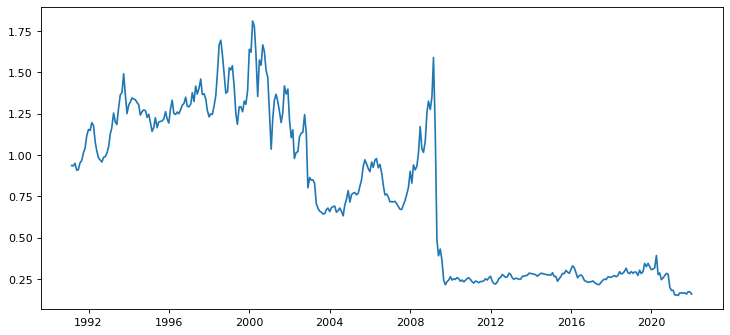

In [18]:
# point a)

#momentum strategy 

#vectors containing all the date from 1990 to 2021 
unique_date = data.date[0:384]

port = pd.DataFrame(index = unique_date).iloc[13:384, ]  #creating an empty Dataframe with the index given by date 

#here what we do is starting by taking the first year ( 12 months) to decide which firm going long and which 
#to short and then we take the returns of these two portfolio from february of 1991 because we buy in january and we got returns in febrauary 

monthly_long = []   #empty list to save the permno to long each period 
monthly_short = []   #empty list to save the permno to short each period 

def add_one(x):
    return x + 1

for i in range(0, 384-13):
    d = (unique_date[i:i+12])   #dates to use to get long and short firms 
    d_plus = unique_date[i+13]     #dates to take returns at each time 
    
    df = data.loc[data.date.isin(d)].get(["permno", "ret"])      #selecting observations with dates in d 
    df["ret"]  = df.ret.apply(add_one) 
    index_sel = df.groupby("permno").prod().sort_values(by="ret", ascending=False).index.values    #here we take the return over one year from simple returns 
    long_permno = index_sel[:10]    #selecting the best 10 firms 
    monthly_long.append(long_permno)  
    short_permno = index_sel[-10:]   #selecting the worst 10 firms 
    monthly_short.append(short_permno)                          
    
    port.at[d_plus, "long"] = data.loc[data.date==d_plus].loc[data.permno.isin(long_permno)].ret.sum().item() *(1/10)   #summing up return of long firm 
    port.at[d_plus, "short"] = data.loc[data.date==d_plus].loc[data.permno.isin(short_permno)].ret.sum().item() *(1/10)  #summing up return of short  firm
    port.at[d_plus, "strat"] = port.at[d_plus, "long"] - port.at[d_plus, "short"] 

    
#plot cumulative return plot 
plt.plot(((port.strat) + 1).cumprod(), label ="MOM")


#mean 
print("Annualized mean ", port.strat.mean()*12)

#variance 
print("Annualized standard deviation ", port.strat.std() * np.sqrt(12))

#calculate sharpe ratio 
monthly = rf.tmytm/12
risk_free = np.exp(monthly.values/100)-1

sr = 12* (port.strat-risk_free[13:]).mean() / ( port.strat.std() * np.sqrt(12) ) 
print("Annualized Sharpe ratio ", sr)

In [19]:
#point b 
#we do a simple regression model 
import statsmodels.api as sm

market = vw_market.loc[vw_market.index.isin(port.index)]
market = market.assign(vwretd = market.vwretd - risk_free[13:] ) #excess martket return 


port12 = port_12.loc[port_12.index.isin(port.index)]/100
port12 = port12.drop(columns= "date")

X = port12.to_numpy()
X = np.concatenate((market, X),axis=1)
y = port.strat.to_numpy()

#add constant to predictor variables
X = sm.add_constant(X)

#fit linear regression model
model = sm.OLS(y, X).fit()  

#view model summary
var12 = ["const", "Market"]
port12_name =  port12.columns.values.tolist()
print(model.summary(xname=var12 + port12_name))

#the factors that are significant drivers of the strategy are the Market, Durbl, Enrgy, Telcm, Money.
#We can see that the alpha is not significantly different from 0, then we can concluse that these factors explain the strategy 
#performance well. 
#The R^2 is not particularly high, but this index represents the percentage of volatility explained by the factors adn therefore
#we can assess that these factors are able be drivers of the returns but they are not good drivers for the idiosyncratic volatility in the returns

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     9.786
Date:                Mon, 02 May 2022   Prob (F-statistic):           1.53e-17
Time:                        23:03:10   Log-Likelihood:                 485.21
No. Observations:                 371   AIC:                            -942.4
Df Residuals:                     357   BIC:                            -887.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0076      0.004      1.897      0.0

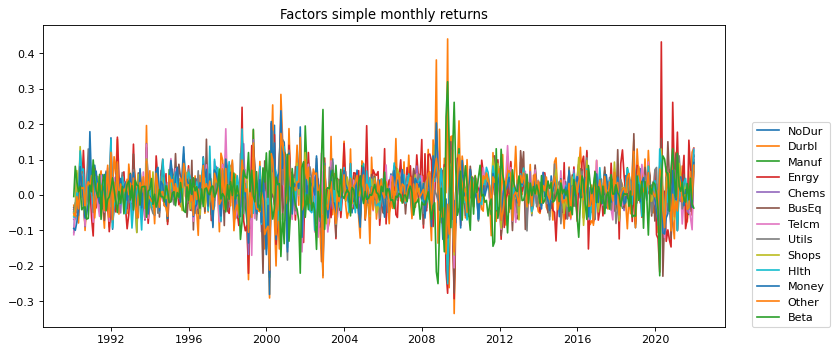

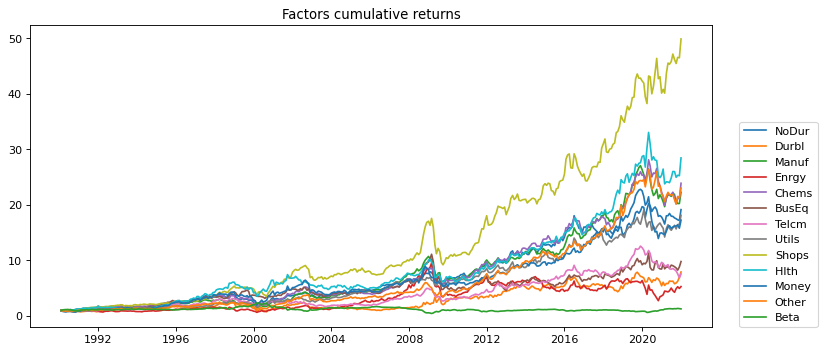

In [23]:
#POINT C

#now we need to estimate the beta for each of the stock selected  

df_dummy=pd.DataFrame(index=index_to_keep, columns = port_12.columns.values[1:])  #empty dataframe to fill 

for p in index_to_keep:
    code = data.loc[data.permno == p].hsiccd.values[0]   #using function for industry code
    data.loc[data.permno == p, "code"] = industry(code) 
    df_dummy.loc[p] = np.zeros(12)    
    df_dummy.loc[p, industry(code)] = 1    

#here we want to calculate beta we can use the formula of beta given by the covariance between excess return of the stock between the covariance of 
#excess market return divided by the variance of the latter 
vw_market["excess"] = vw_market.vwretd - risk_free

def calc_beta(ret):   #calculating beta 
    return np.cov((ret-risk_free), vw_market.excess)[0,1]/np.var(vw_market.excess)

beta = data.groupby("permno").ret.apply(calc_beta)
df_reg = pd.concat((df_dummy, beta), axis=1)
df_reg = df_reg.rename(columns={"ret": "Beta"})


#estimate the unobservabe monthly factors return by running every month a cross sectional regression of the stock returns onto their exposure 
#for each month my y will be the stock returns while the X will be given by the exposure of each stock 


def factors_return():
    factors_return = []
    tstat = []
    X = df_reg.to_numpy(dtype="float")
    for i in unique_date.values:  #for each date 
        y = data.loc[data.date == i].set_index(df_reg.index).ret.values
        model = sm.OLS(y, X).fit()  #fitting the regression model for each date
        tstat.append(model.tvalues)   #saving the t stats
        factors_return.append(model.params)   #and the parameters of the model 
    return factors_return, tstat    

factors, tstat = factors_return()
fac = pd.DataFrame(factors, index = unique_date)
fac.columns = df_reg.columns

#returns
for col in fac.columns:
    plt.plot(fac[col], label = col)
plt.legend(loc=(1.04,0))
plt.title("Factors simple monthly returns")
plt.show()

#cumulative returns 
for col in fac.columns:
    plt.plot((fac[col]+1).cumprod(), label = col)
plt.legend(loc=(1.04,0))
plt.title("Factors cumulative returns")
plt.show()

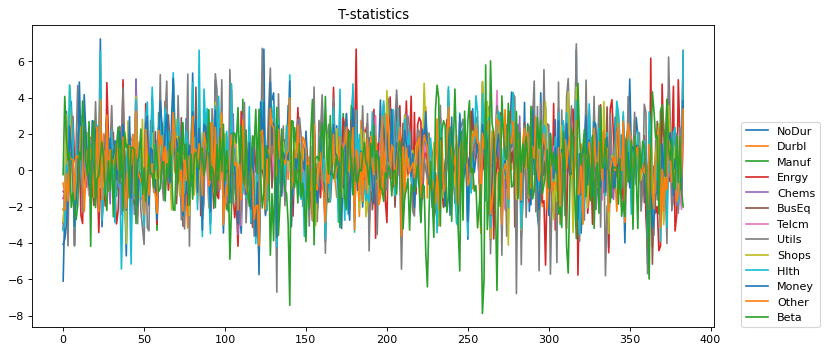

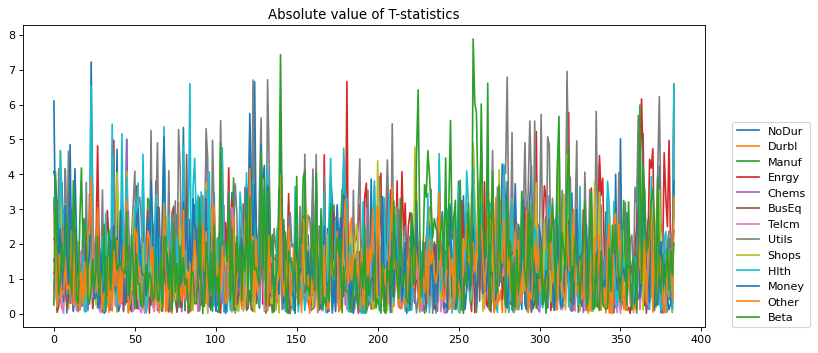

Average of tstat
Utils    0.529121
Shops    0.468464
Hlth     0.463102
NoDur    0.443459
Manuf    0.378143
Chems    0.353740
Other    0.339118
Money    0.333124
Enrgy    0.249706
BusEq    0.224987
Telcm    0.186113
Durbl    0.146305
Beta     0.044653
dtype: float64

Average of absolute value of tstat
Utils    2.072601
Hlth     1.643110
Beta     1.640884
Enrgy    1.617101
NoDur    1.603710
Money    1.363048
Manuf    1.338819
Shops    1.324978
Other    1.257443
Chems    1.216026
BusEq    1.155171
Durbl    1.144787
Telcm    0.979969
dtype: float64

Variance of tstats
NoDur    4.078540
Durbl    1.995495
Manuf    2.566613
Enrgy    4.119462
Chems    2.217595
BusEq    2.106812
Telcm    1.501890
Utils    6.376284
Shops    2.666629
Hlth     4.302416
Money    2.804446
Other    2.255674
Beta     4.569490
dtype: float64


In [25]:
#plot the time series of monthly t-statistics  and report the average t-statistics associated with each factors
#as well as the avererage absolute value of each t-statistics 
df_tstat = pd.DataFrame(tstat, columns=fac.columns)
df_tstat.plot()
plt.legend(loc=(1.04,0))
plt.title("T-statistics")
plt.show()

#absolute value of tstat 
df_tstat.abs().plot()
plt.legend(loc=(1.04,0))
plt.title("Absolute value of T-statistics")
plt.show()

#reporting of statistics regarding tstat values 
print(f"Average of tstat\n{df_tstat.mean().sort_values(ascending=False)}\n")
print(f"Average of absolute value of tstat\n{df_tstat.abs().mean().sort_values(ascending=False)}")

#we can report also the variance of tstat in order to see which of them had more variation
print(f"\nVariance of tstats\n{df_tstat.var()}")

#the factors that have the largest tvalues on average are Utils, Shops , Hlth adn NoDur.

#but it is important to note that also the market factors has a large average when we consider the absolute value of the t-statistic.
#This could mean that the market beta varies a lot over tim, in fact its variance is high compared to other factors.
#We can see that also Energy has a similar behaviour.

#We can interpret these movement in the t-statistic as there are some factors that are more subject to period of significant importance in driving the returns 
#and in some periods they can be positive source of returns and in other they could explain the fall in returns 





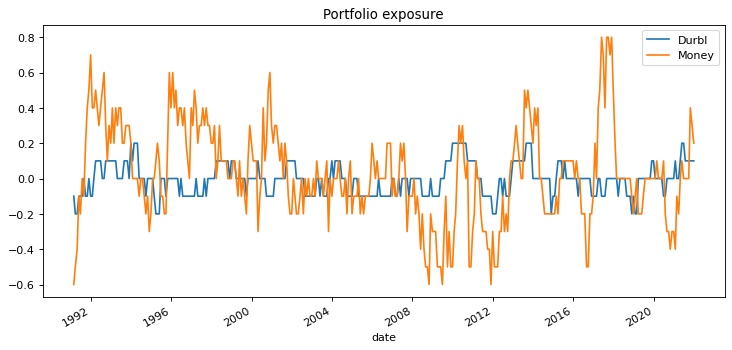

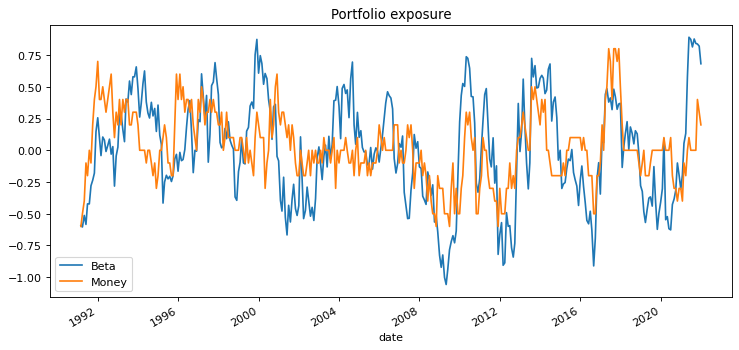

In [38]:
#POINT D


#Using the monthly weights of your momentum trading strategy and the individual
#stock exposures, compute the monthly time series of your strategy's exposure to
#the 13 factors

#here we have the permno used to go long and short in each month 
#here we have individual stock exposure df_reg

#for eahc month we will have different exposure
#example
#I am not sure about this 
exposure = []
for long, short in zip(monthly_long, monthly_short):
    exposure.append(1/10 * df_reg.loc[df_reg.index.isin(long)].sum(axis=0)  - 1/10 * df_reg.loc[df_reg.index.isin(short)].sum(axis=0))

exp = pd.DataFrame(exposure, columns = fac.columns, index=unique_date[13:])
#exp is the dataframe that contains the exposure of the momentum strategy 

exp.loc[:,["Durbl", "Money"]].plot()
plt.title("Portfolio exposure")
plt.show()

#choose the one that seems to be the best ones and explain the risk 
#based on t-statistic of the first regression we choose Durbl and Money
#we could also take Market but it is possibile to see that the exposure to MArket is quite similar to the exposure to Money 
#we can see it from the second plot 

exp.loc[:,["Beta", "Money"]].plot()
plt.title("Portfolio exposure")
plt.show()



Annualized mean  -0.01013415932946824
Annualized standard deviation  0.14157782989648462
Annualized Sharpe ratio  -0.23397921792449156




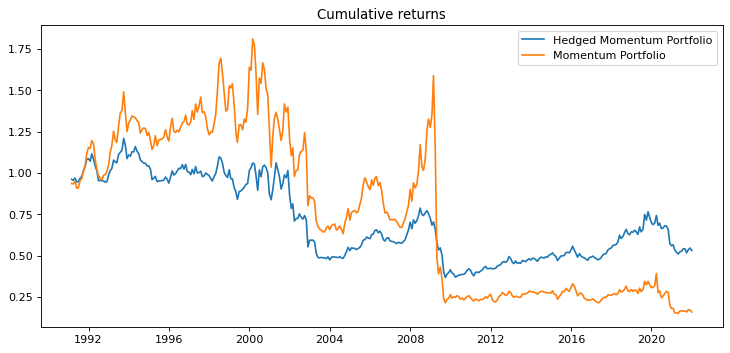

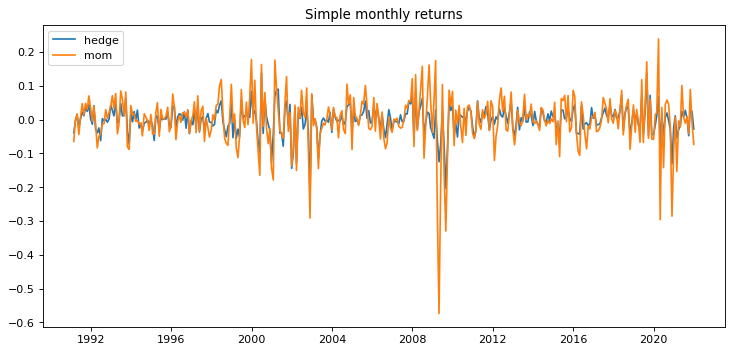

In [50]:
#hedged momentum portfolio 
#it is the momentum strategy return - factors*exposure

#we can create the portfolio to short 
#short_port = pd.concat
#we take the factors dataframe starting from February 1991 and the exposure dataframe 
short_port = fac.loc[fac.index.isin(unique_date[13:])] * exp
hedged = port.strat - short_port.sum(axis=1)


#mean 
print("Annualized mean ", hedged.mean()*12)

#variance 
print("Annualized standard deviation ", hedged.std() * np.sqrt(12))

#calculate sharpe ratio 
sr_hedged = 12* (hedged - risk_free[13:]).mean() / ( hedged.std() * np.sqrt(12) ) 
print("Annualized Sharpe ratio ", sr_hedged)
print("\n")


#we can visualize the results 
plt.plot((hedged + 1).cumprod(), label = "Hedged Momentum Portfolio")
plt.plot((port.strat +1).cumprod(), label = "Momentum Portfolio ")
plt.legend()
plt.title("Cumulative returns")
plt.show()


plt.plot(hedged,label = "hedge")
plt.plot(port.strat, label = "mom")
plt.legend()
plt.title("Simple monthly returns")
plt.show()


#we can see from both cumulative returns and simple monthly returns that the hedged portfolio is less volatile than the 
#momentum strategy portfolio 
#but from these result we can also see that we are not able to hedge perfectly the portfolios using these 12 factors + market
#the annualized mean is still negative, but less, and we have a reduction in standard deviation 

